<a href="https://colab.research.google.com/github/AbhiramSankar/Comparison-of-GA-DE-and-PSO-on-Rastrigin-function/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import files

In [ ]:
# Parameter Tuning
# Common
POP_SIZE = 100          # Larger population
MAX_GEN = 500          # More generations
TOLERANCE = 1e-10       # Stopping criterion

# GA Parameters
GA_PC = 0.75           # Crossover probability
GA_PM = 0.09           # Mutation probability
GA_PM_INIT = 0.01      # Initial mutation probability (for Improved GA)
GA_PM_FINAL = 0.09     # Final mutation probability (for Improved GA)
ELITISM = True         # Keep best individual each generation (for Improved GA)

# DE Parameters
DE_F = 0.8             # Mutation factor
DE_CR = 0.8            # Crossover rate

# PSO Parameters
PSO_W = 0.7            # Inertia weight
PSO_W_START = 0.9      # Initial inertia weight (for Improved PSo)
PSO_W_END = 0.4        # Final inertia weight (for Improved PSO)
PSO_C1 = 1.5           # Cognitive coefficient
PSO_C2 = 1.5           # Social coefficient

In [ ]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Rastrigin function
def rastrigin(X):
    x, y = X
    return 20 + x**2 + y**2 - 10*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))

# Domain
lower_bound, upper_bound = -5.12, 5.12
DIM = 2

# Initialize population
def initialize_population(size, dim, lb, ub):
    return np.random.uniform(lb, ub, (size, dim))

# Tournament Selection for GA
def tournament_selection(population, fitness, k=3):
    """Select one individual using tournament selection."""
    selected_idx = np.random.choice(len(population), k, replace=False)
    best_idx = selected_idx[np.argmin(fitness[selected_idx])]  # Minimization
    return population[best_idx]

# Logging
def log_results(filename, fitness_log):
    df = pd.DataFrame({"Generation": range(1, len(fitness_log)+1), "Best Fitness": fitness_log})
    df.to_csv(filename, index=False)

In [ ]:
# Genetic Algorithm (GA)

def run_ga():
    population = initialize_population(POP_SIZE, DIM, lower_bound, upper_bound)
    fitness_log = []

    for gen in range(MAX_GEN):
        # Evaluate fitness for current population
        fitness = np.array([rastrigin(ind) for ind in population])
        best_idx = np.argmin(fitness)
        best_value = fitness[best_idx]
        fitness_log.append(best_value)

        if gen % 10 == 0 or best_value <= TOLERANCE:
            print(f"GA - Gen {gen+1}, Best Fitness: {best_value:.10f}")

        if best_value <= TOLERANCE:
            print(f"GA reached global minimum at gen {gen+1}")
            print(f"Best Coordinates: {population[best_idx]}, Value: {best_value:.10f}")
            break

        new_pop = []
        for _ in range(POP_SIZE // 2):
            # Select two parents via tournament selection
            p1 = tournament_selection(population, fitness, k=3)
            p2 = tournament_selection(population, fitness, k=3)

            # Crossover
            if np.random.rand() < GA_PC:
                alpha = np.random.rand()
                child1 = alpha * p1 + (1 - alpha) * p2
                child2 = alpha * p2 + (1 - alpha) * p1
            else:
                child1, child2 = p1.copy(), p2.copy()

            # Mutation
            for child in [child1, child2]:
                if np.random.rand() < GA_PM:
                    idx = np.random.randint(0, DIM)
                    child[idx] += np.random.normal(0, 0.1)
                    child[idx] = np.clip(child[idx], lower_bound, upper_bound)

            new_pop.extend([child1, child2])

        population = np.array(new_pop)
    else:
        # Runs only if loop did NOT break early
        print(f"GA finished all {MAX_GEN} generations.")
        print(f"Best found: {population[best_idx]}, Value: {best_value:.10f}")

    log_results("results/ga.csv", fitness_log)
    return fitness_log

ga_log = run_ga()


GA - Gen 1, Best Fitness: 2.1490987001
GA - Gen 11, Best Fitness: 0.0748032379
GA - Gen 21, Best Fitness: 0.0006444318
GA - Gen 31, Best Fitness: 0.0006729647
GA - Gen 41, Best Fitness: 0.0003943945
GA - Gen 51, Best Fitness: 0.0004092665
GA - Gen 61, Best Fitness: 0.0004096827
GA - Gen 71, Best Fitness: 0.0000299581
GA - Gen 81, Best Fitness: 0.0000405326
GA - Gen 91, Best Fitness: 0.0000259537
GA - Gen 101, Best Fitness: 0.0000260475
GA - Gen 111, Best Fitness: 0.0000260475
GA - Gen 121, Best Fitness: 0.0000173504
GA - Gen 131, Best Fitness: 0.0000173324
GA - Gen 141, Best Fitness: 0.0000173323
GA - Gen 151, Best Fitness: 0.0000173323
GA - Gen 161, Best Fitness: 0.0000173323
GA - Gen 171, Best Fitness: 0.0000173323
GA - Gen 181, Best Fitness: 0.0000173323
GA - Gen 191, Best Fitness: 0.0000173323
GA - Gen 201, Best Fitness: 0.0000173323
GA - Gen 211, Best Fitness: 0.0000173323
GA - Gen 221, Best Fitness: 0.0000173323
GA - Gen 231, Best Fitness: 0.0000173323
GA - Gen 241, Best Fitness:

In [ ]:
# Improved Genetic Algorithm (GA)
def run_ga():
    population = initialize_population(POP_SIZE, DIM, lower_bound, upper_bound)
    fitness_log = []

    for gen in range(MAX_GEN):
        fitness = np.array([rastrigin(ind) for ind in population])
        best_idx = np.argmin(fitness)
        best_value = fitness[best_idx]
        best_individual = population[best_idx]
        fitness_log.append(best_value)

        if gen % 10 == 0 or best_value <= TOLERANCE:
            print(f"GA - Gen {gen+1}, Best Fitness: {best_value:.10f}")

        if best_value <= TOLERANCE:
            print(f"GA reached global minimum at gen {gen+1}")
            print(f"Best Coordinates: {best_individual}, Value: {best_value:.10f}")
            break

        # Elitism
        elite = best_individual.copy()

        # Adaptive mutation
        GA_PM = GA_PM_INIT - (GA_PM_INIT - GA_PM_FINAL) * (gen / MAX_GEN)
        if gen == MAX_GEN-1:
          print(f"GA_PM = {GA_PM}")

        new_pop = [elite] if ELITISM else []
        while len(new_pop) < POP_SIZE:
            p1 = tournament_selection(population, fitness, k=3)
            p2 = tournament_selection(population, fitness, k=3)

            # Crossover
            if np.random.rand() < GA_PC:
                alpha = np.random.rand()
                child1 = alpha * p1 + (1 - alpha) * p2
                child2 = alpha * p2 + (1 - alpha) * p1
            else:
                child1, child2 = p1.copy(), p2.copy()

            # Mutation
            for child in [child1, child2]:
                if np.random.rand() < GA_PM:
                    idx = np.random.randint(0, DIM)
                    child[idx] += np.random.normal(0, 0.2)
                    child[idx] = np.clip(child[idx], lower_bound, upper_bound)

            new_pop.extend([child1, child2])

        population = np.array(new_pop[:POP_SIZE])
    else:
        # Runs only if loop did NOT break early
        print(f"GA finished all {MAX_GEN} generations.")
        print(f"Best found: {population[best_idx]}, Value: {best_value:.10f}")

    log_results("results/improved_ga.csv", fitness_log)
    return fitness_log

imp_ga_log = run_ga()

GA - Gen 1, Best Fitness: 10.3909751398
GA - Gen 11, Best Fitness: 0.0064767020
GA - Gen 21, Best Fitness: 0.0003689176
GA - Gen 31, Best Fitness: 0.0003676471
GA - Gen 41, Best Fitness: 0.0003676471
GA - Gen 51, Best Fitness: 0.0003676471
GA - Gen 61, Best Fitness: 0.0002436197
GA - Gen 71, Best Fitness: 0.0002434553
GA - Gen 81, Best Fitness: 0.0002434553
GA - Gen 91, Best Fitness: 0.0002434553
GA - Gen 101, Best Fitness: 0.0002434553
GA - Gen 111, Best Fitness: 0.0002434553
GA - Gen 121, Best Fitness: 0.0002434553
GA - Gen 131, Best Fitness: 0.0002434553
GA - Gen 141, Best Fitness: 0.0002434553
GA - Gen 151, Best Fitness: 0.0002434553
GA - Gen 161, Best Fitness: 0.0000000194
GA - Gen 163, Best Fitness: 0.0000000000
GA reached global minimum at gen 163
Best Coordinates: [-4.43229557e-07  7.13109177e-11], Value: 0.0000000000


In [ ]:
# Differential Evolution (DE)
def run_de():
    population = initialize_population(POP_SIZE, DIM, lower_bound, upper_bound)
    fitness_log = []

    for gen in range(MAX_GEN):
        fitness = np.array([rastrigin(ind) for ind in population])
        best_idx = np.argmin(fitness)
        best_value = fitness[best_idx]
        fitness_log.append(best_value)

        if gen % 10 == 0 or best_value <= TOLERANCE:
            print(f"DE - Gen {gen+1}, Best Fitness: {best_value:.10f}")

        if best_value <= TOLERANCE:
            print(f"DE reached global minimum at gen {gen+1}")
            print(f"Best Coordinates: {population[best_idx]}, Value: {best_value:.10f}")
            break

        new_pop = []
        for i in range(POP_SIZE):
            idxs = [idx for idx in range(POP_SIZE) if idx != i]
            a, b, c = population[np.random.choice(idxs, 3, replace=False)]
            mutant = a + DE_F * (b - c)
            mutant = np.clip(mutant, lower_bound, upper_bound)

            cross_points = np.random.rand(DIM) < DE_CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, DIM)] = True
            trial = np.where(cross_points, mutant, population[i])

            if rastrigin(trial) < rastrigin(population[i]):
                new_pop.append(trial)
            else:
                new_pop.append(population[i])

        population = np.array(new_pop)
    else:
        # Runs only if loop did NOT break early
        print(f"DE finished all {MAX_GEN} generations.")
        print(f"Best found: {population[best_idx]}, Value: {best_value:.10f}")

    log_results("results/de.csv", fitness_log)
    return fitness_log

de_log = run_de()

DE - Gen 1, Best Fitness: 5.7621552407
DE - Gen 11, Best Fitness: 0.6028822555
DE - Gen 21, Best Fitness: 0.1976430513
DE - Gen 31, Best Fitness: 0.1976430513
DE - Gen 41, Best Fitness: 0.1374564888
DE - Gen 51, Best Fitness: 0.0238334038
DE - Gen 61, Best Fitness: 0.0002390355
DE - Gen 71, Best Fitness: 0.0000004870
DE - Gen 81, Best Fitness: 0.0000004870
DE - Gen 91, Best Fitness: 0.0000000293
DE - Gen 101, Best Fitness: 0.0000000004
DE - Gen 109, Best Fitness: 0.0000000000
DE reached global minimum at gen 109
Best Coordinates: [ 4.19831910e-07 -2.22363868e-07], Value: 0.0000000000


In [ ]:
# Particle Swarm Optimization (PSO)
def run_pso():
    positions = initialize_population(POP_SIZE, DIM, lower_bound, upper_bound)
    velocities = np.zeros((POP_SIZE, DIM))
    pbest_positions = positions.copy()
    pbest_values = np.array([rastrigin(ind) for ind in positions])
    gbest_idx = np.argmin(pbest_values)
    gbest_position = pbest_positions[gbest_idx]
    fitness_log = []

    for gen in range(MAX_GEN):
        for i in range(POP_SIZE):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (PSO_W * velocities[i] +
                             PSO_C1 * r1 * (pbest_positions[i] - positions[i]) +
                             PSO_C2 * r2 * (gbest_position - positions[i]))
            positions[i] += velocities[i]
            positions[i] = np.clip(positions[i], lower_bound, upper_bound)

            fitness = rastrigin(positions[i])
            if fitness < pbest_values[i]:
                pbest_values[i] = fitness
                pbest_positions[i] = positions[i]

        gbest_idx = np.argmin(pbest_values)
        gbest_position = pbest_positions[gbest_idx]
        fitness_log.append(pbest_values[gbest_idx])

        if gen % 10 == 0 or fitness_log[-1] <= TOLERANCE:
            print(f"PSO - Gen {gen+1}, Best Fitness: {fitness_log[-1]:.10f}")

        if fitness_log[-1] <= TOLERANCE:
            print(f"PSO reached global minimum at gen {gen+1}")
            print(f"Best Coordinates: {gbest_position}, Value: {fitness_log[-1]:.10f}")
            break

    else:
        # Runs only if loop did NOT break early
        print(f"PSO finished all {MAX_GEN} generations.")
        print(f"Best found: {gbest_position}, Value: {fitness_log[-1]:.10f}")

    log_results("results/pso.csv", fitness_log)
    return fitness_log

pso_log = run_pso()

PSO - Gen 1, Best Fitness: 4.1167218270
PSO - Gen 11, Best Fitness: 0.2419928513
PSO - Gen 21, Best Fitness: 0.0001782211
PSO - Gen 31, Best Fitness: 0.0001394867
PSO - Gen 41, Best Fitness: 0.0000009355
PSO - Gen 51, Best Fitness: 0.0000001650
PSO - Gen 61, Best Fitness: 0.0000000030
PSO - Gen 71, Best Fitness: 0.0000000003
PSO - Gen 81, Best Fitness: 0.0000000002
PSO - Gen 90, Best Fitness: 0.0000000001
PSO reached global minimum at gen 90
Best Coordinates: [-5.64133942e-07  1.22884921e-08], Value: 0.0000000001


In [ ]:
# Improved Particle Swarm Optimization (PSO)
def run_pso():
    positions = initialize_population(POP_SIZE, DIM, lower_bound, upper_bound)
    velocities = np.zeros((POP_SIZE, DIM))
    pbest_positions = positions.copy()
    pbest_values = np.array([rastrigin(ind) for ind in positions])
    gbest_idx = np.argmin(pbest_values)
    gbest_position = pbest_positions[gbest_idx]
    fitness_log = []

    v_max = (upper_bound - lower_bound) * 0.2

    for gen in range(MAX_GEN):
        # Inertia decay
        w = PSO_W_START - (PSO_W_START - PSO_W_END) * (gen / MAX_GEN)

        for i in range(POP_SIZE):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (w * velocities[i] +
                             PSO_C1 * r1 * (pbest_positions[i] - positions[i]) +
                             PSO_C2 * r2 * (gbest_position - positions[i]))
            velocities[i] = np.clip(velocities[i], -v_max, v_max)
            positions[i] += velocities[i]
            positions[i] = np.clip(positions[i], lower_bound, upper_bound)

            fitness = rastrigin(positions[i])
            if fitness < pbest_values[i]:
                pbest_values[i] = fitness
                pbest_positions[i] = positions[i]

        gbest_idx = np.argmin(pbest_values)
        gbest_position = pbest_positions[gbest_idx]
        fitness_log.append(pbest_values[gbest_idx])

        if gen % 20 == 0 or fitness_log[-1] <= TOLERANCE:
            print(f"PSO - Gen {gen+1}, Best Fitness: {fitness_log[-1]:.10f}")

        if fitness_log[-1] <= TOLERANCE:
            print(f"PSO reached global minimum at gen {gen+1}")
            print(f"Best Coordinates: {gbest_position}, Value: {fitness_log[-1]:.10f}")
            break
    else:
        # Runs only if loop did NOT break early
        print(f"PSO finished all {MAX_GEN} generations.")
        print(f"Best found: {gbest_position}, Value: {fitness_log[-1]:.10f}")

    log_results("results/improved_pso.csv", fitness_log)
    return fitness_log

imp_pso_log = run_pso()

PSO - Gen 1, Best Fitness: 0.2247657517
PSO - Gen 21, Best Fitness: 0.0105759278
PSO - Gen 41, Best Fitness: 0.0002415598
PSO - Gen 61, Best Fitness: 0.0000299393
PSO - Gen 81, Best Fitness: 0.0000047508
PSO - Gen 101, Best Fitness: 0.0000000689
PSO - Gen 121, Best Fitness: 0.0000000192
PSO - Gen 141, Best Fitness: 0.0000000008
PSO - Gen 146, Best Fitness: 0.0000000000
PSO reached global minimum at gen 146
Best Coordinates: [-2.26816881e-07 -1.23868092e-07], Value: 0.0000000000


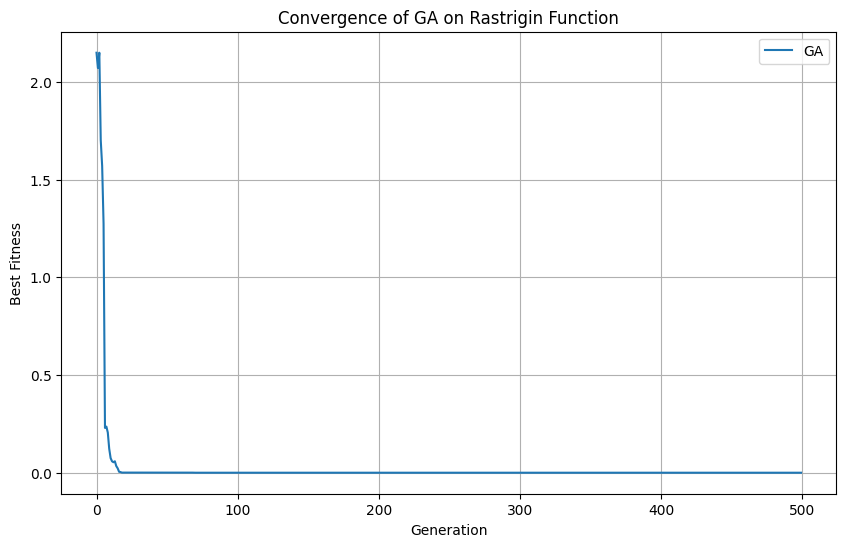

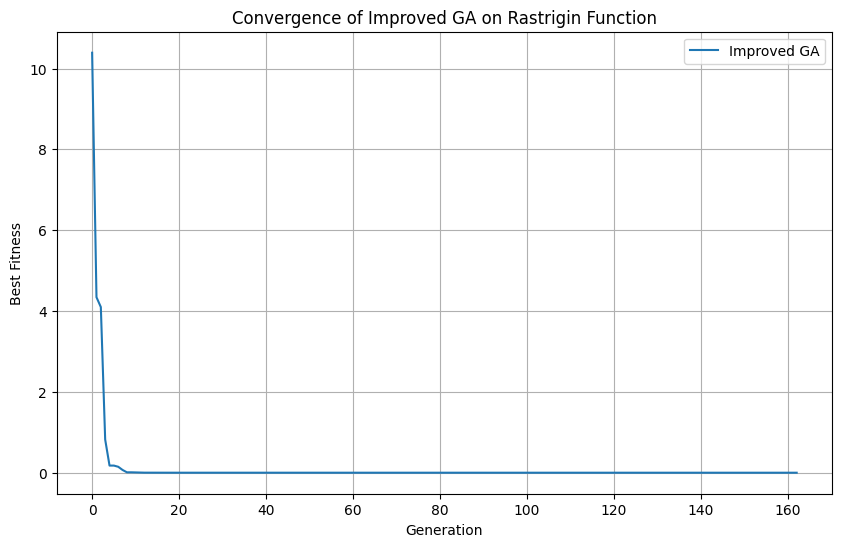

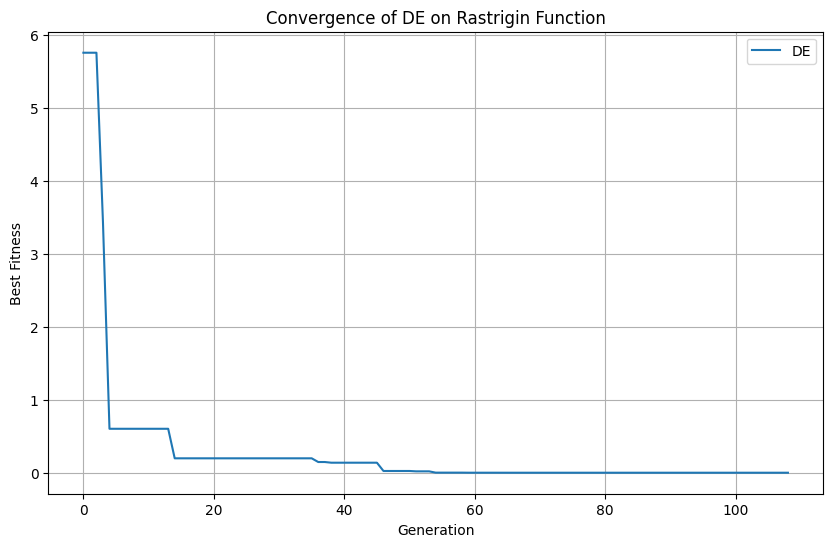

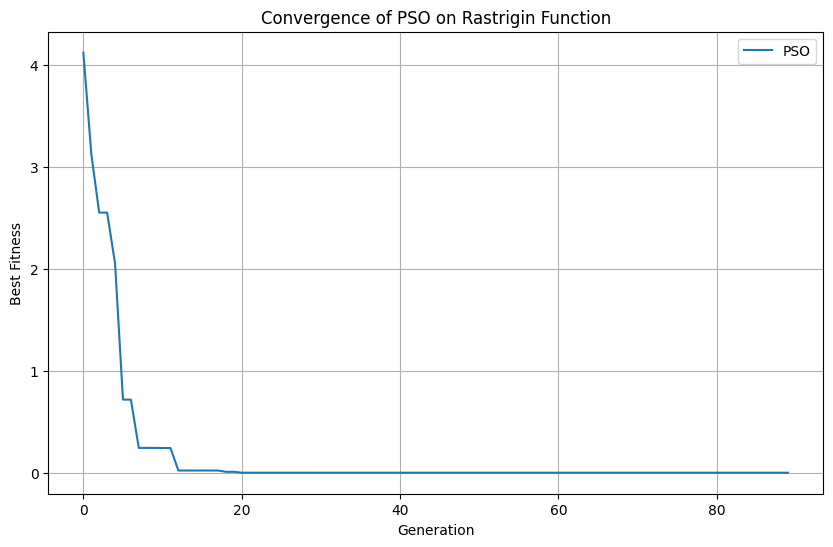

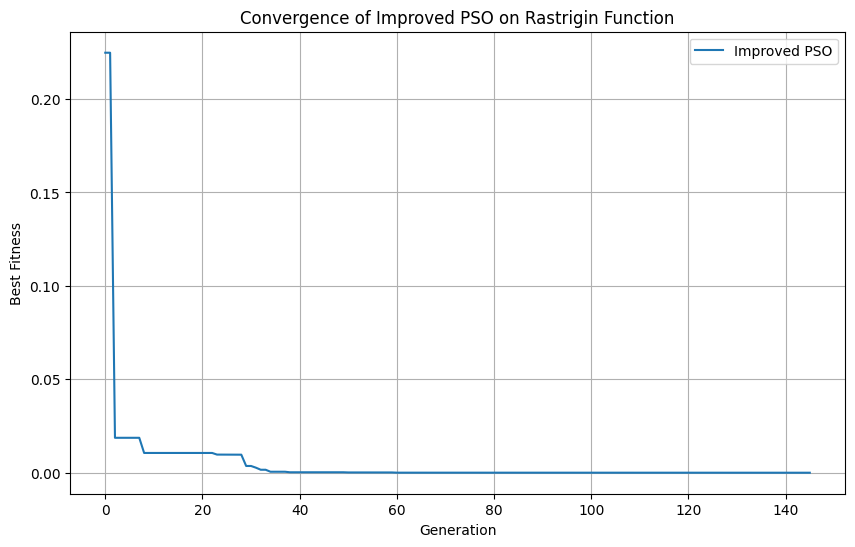

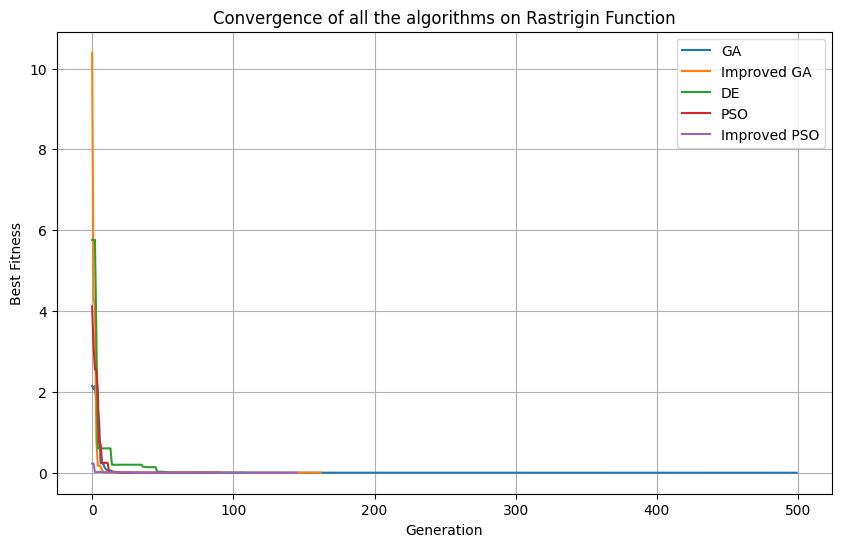

In [ ]:
# Plot and Compare Convergence

# GA
plt.figure(figsize=(10, 6))
plt.plot(ga_log, label='GA')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Convergence of GA on Rastrigin Function')
plt.legend()
plt.grid()
plt.savefig('results/GAconvergence.png')
plt.show()

# Improved GA
plt.figure(figsize=(10, 6))
plt.plot(imp_ga_log, label='Improved GA')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Convergence of Improved GA on Rastrigin Function')
plt.legend()
plt.grid()
plt.savefig('results/impGAconvergence.png')
plt.show()

# DE
plt.figure(figsize=(10, 6))
plt.plot(de_log, label='DE')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Convergence of DE on Rastrigin Function')
plt.legend()
plt.grid()
plt.savefig('results/DEconvergence.png')
plt.show()

# PSO
plt.figure(figsize=(10, 6))
plt.plot(pso_log, label='PSO')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Convergence of PSO on Rastrigin Function')
plt.legend()
plt.grid()
plt.savefig('results/PSOconvergence.png')
plt.show()

# Improved PSO
plt.figure(figsize=(10, 6))
plt.plot(imp_pso_log, label='Improved PSO')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Convergence of Improved PSO on Rastrigin Function')
plt.legend()
plt.grid()
plt.savefig('results/impPSOconvergence.png')
plt.show()

# Overall
plt.figure(figsize=(10, 6))
plt.plot(ga_log, label='GA')
plt.plot(imp_ga_log, label='Improved GA')
plt.plot(de_log, label='DE')
plt.plot(pso_log, label='PSO')
plt.plot(imp_pso_log, label='Improved PSO')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Convergence of all the algorithms on Rastrigin Function')
plt.legend()
plt.grid()
plt.savefig('results/convergence.png')
plt.show()

In [ ]:
# Download Results
files.download('results/ga.csv')
files.download('results/improved_ga.csv')
files.download('results/de.csv')
files.download('results/pso.csv')
files.download('results/improved_pso.csv')
files.download('results/GAconvergence.png')
files.download('results/impGAconvergence.png')
files.download('results/DEconvergence.png')
files.download('results/PSOconvergence.png')
files.download('results/impPSOconvergence.png')
files.download('results/convergence.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>